# Pose Linear Metrics Statistical Analysis

This notebook performs comprehensive statistical analysis on all pose linear metrics using mixed-effects models and generates publication-ready figures.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
import warnings
warnings.filterwarnings('ignore')

# Load session information
Session_Info = pd.read_csv(Path("data") / "pose_data" / "participant_info.csv")

# Add session_order column to Session_Info
if {"session01", "session02", "session03"}.issubset(Session_Info.columns):
    Session_Info["session_order"] = (
        Session_Info["session01"].str[0] +
        Session_Info["session02"].str[0] +
        Session_Info["session03"].str[0]
    )

# Prepare session_order and session_order_numeric maps
session_order_numeric_map = {"LMH": 1, "LHM": 2}
session_order_map = {}
if "session_order" in Session_Info.columns:
    session_order_map = Session_Info.set_index("Participant ID")["session_order"].to_dict()

# Standardize condition values
cond_map = {"low": "L", "moderate": "M", "hard": "H", "l": "L", "m": "M", "h": "H"}

print("Session information loaded successfully")
print(f"Total participants: {len(Session_Info)}")

Session information loaded successfully
Total participants: 50


In [3]:
# Load all three normalization methods for pose linear metrics
linear_metrics_dir = Path("data") / "processed" / "linear_metrics"

pose_data = {}

# Load each normalization method if it exists
for method in ["original", "procrustes_global", "procrustes_participant"]:
    file_path = linear_metrics_dir / f"{method}_linear.csv"
    if file_path.exists():
        df = pd.read_csv(file_path)
        
        # Add session order information
        if "participant" in df.columns and session_order_map:
            df["session_order"] = df["participant"].map(session_order_map)
            df["session_order_numeric"] = df["session_order"].map(session_order_numeric_map)
        
        # Standardize condition values
        if "condition" in df.columns:
            df["condition"] = df["condition"].astype(str).str.strip().str.upper()
            # Ensure L, M, H format
            df["condition"] = df["condition"].map(lambda x: cond_map.get(x.lower(), x))
        
        pose_data[method] = df
        print(f"Loaded {method}: {df.shape[0]} rows, {df.shape[1]} columns")
    else:
        print(f"Warning: {method}_linear.csv not found")

# Get list of all metric columns (excluding metadata)
metadata_cols = {"source", "participant", "condition", "window_index", "t_start_frame", "t_end_frame", 
                "session_order", "session_order_numeric"}

if pose_data:
    # Get metrics from first available dataset
    sample_df = next(iter(pose_data.values()))
    all_metric_cols = [col for col in sample_df.columns if col not in metadata_cols]
    print(f"\nFound {len(all_metric_cols)} total metrics")
    print("All available metrics:")
    for i, metric in enumerate(all_metric_cols, 1):
        print(f"  {i:2d}. {metric}")

# ===== CONFIGURATION: SELECT METRICS TO ANALYZE =====
# You can modify this section to choose which metrics to analyze and plot

# Option 1: Analyze ALL metrics (default)
ANALYZE_ALL_METRICS = True

# Option 2: Analyze specific metrics by name
SELECTED_METRICS = [
    # Head rotation metrics
    "head_rotation_rad_mean_abs_vel",
    "head_rotation_rad_rms", 
    
    # Blink metrics
    "blink_aperture_mean_abs_vel",
    "blink_aperture_rms",
    
    # Mouth metrics  
    "mouth_aperture_mean_abs_vel",
    "mouth_aperture_rms",
    
    # Pupil metrics
    "pupil_dx_rms",
    "pupil_dy_rms",
    "pupil_metric_rms",
    
    # Center face metrics
    "center_face_magnitude_rms",
    "center_face_x_rms", 
    "center_face_y_rms"
]

# Option 3: Analyze metrics by pattern (e.g., only RMS metrics)
METRIC_PATTERNS = ["_rms"]  # ["_rms", "_mean_abs_vel", "_mean_abs_acc"]

# Choose which metrics to use
if ANALYZE_ALL_METRICS:
    metric_cols = all_metric_cols
    print(f"\nWill analyze ALL {len(metric_cols)} metrics")
else:
    if METRIC_PATTERNS:
        # Filter by patterns
        metric_cols = [col for col in all_metric_cols 
                      if any(pattern in col for pattern in METRIC_PATTERNS)]
        print(f"\nWill analyze {len(metric_cols)} metrics matching patterns {METRIC_PATTERNS}")
    else:
        # Use selected metrics
        metric_cols = [col for col in SELECTED_METRICS if col in all_metric_cols]
        missing = [col for col in SELECTED_METRICS if col not in all_metric_cols]
        print(f"\nWill analyze {len(metric_cols)} selected metrics")
        if missing:
            print(f"Warning: {len(missing)} selected metrics not found: {missing}")
    
    print("Selected metrics:")
    for i, metric in enumerate(metric_cols, 1):
        print(f"  {i:2d}. {metric}")

Loaded original: 185 rows, 35 columns
Loaded procrustes_global: 185 rows, 38 columns
Loaded procrustes_participant: 185 rows, 38 columns

Found 27 total metrics
All available metrics:
   1. head_rotation_rad_mean_abs_vel
   2. head_rotation_rad_mean_abs_acc
   3. head_rotation_rad_rms
   4. blink_aperture_mean_abs_vel
   5. blink_aperture_mean_abs_acc
   6. blink_aperture_rms
   7. mouth_aperture_mean_abs_vel
   8. mouth_aperture_mean_abs_acc
   9. mouth_aperture_rms
  10. pupil_dx_mean_abs_vel
  11. pupil_dx_mean_abs_acc
  12. pupil_dx_rms
  13. pupil_dy_mean_abs_vel
  14. pupil_dy_mean_abs_acc
  15. pupil_dy_rms
  16. pupil_metric_mean_abs_vel
  17. pupil_metric_mean_abs_acc
  18. pupil_metric_rms
  19. center_face_magnitude_mean_abs_vel
  20. center_face_magnitude_mean_abs_acc
  21. center_face_magnitude_rms
  22. center_face_x_mean_abs_vel
  23. center_face_x_mean_abs_acc
  24. center_face_x_rms
  25. center_face_y_mean_abs_vel
  26. center_face_y_mean_abs_acc
  27. center_face_y_r

In [4]:
# Check for R packages (skip installation attempts to avoid compilation issues)
import subprocess
import sys

try:
    import rpy2.robjects as ro
    from rpy2.robjects import pandas2ri
    from rpy2.robjects.packages import importr, isinstalled

    # Check if R is available
    ro.r('R.version.string')

    # Check if packages are already installed (don't try to install)
    if isinstalled('lmerTest') and isinstalled('emmeans'):
        # Try to import packages
        lmerTest = importr('lmerTest')
        emmeans = importr('emmeans')
        USE_R = True
        print("R packages found and loaded successfully")
    else:
        print("R packages not installed. Using Python-based statistical analysis instead.")
        print("(To use R, install packages manually in R with: install.packages(c('lmerTest', 'emmeans')))")
        USE_R = False

except Exception as e:
    print(f"R not available or packages missing. Using Python-based statistical analysis instead.")
    USE_R = False

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


R packages found and loaded successfully


In [11]:
# Import statistical libraries
import scipy.stats as stats
from scipy.stats import f_oneway, tukey_hsd
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

if USE_R:
    import rpy2.robjects as robjects
    from rpy2.robjects import pandas2ri
    from rpy2.robjects.packages import importr
    from rpy2.robjects.conversion import localconverter

def run_lmer_python(df, dv, feature_label, verbose=False):
    """
    Fallback: Use Python statsmodels for mixed effects modeling
    """
    # Check which columns are available
    required_cols = ["participant", "condition", dv]
    optional_cols = ["session_order_numeric", "window_index"]
    
    # Build column list based on what's available
    cols = required_cols.copy()
    for col in optional_cols:
        if col in df.columns:
            cols.append(col)
    
    # Check if the dependent variable exists
    if dv not in df.columns:
        if verbose:
            print(f"Column {dv} not found in dataframe")
        return None, None, None
    
    dat = df[cols].dropna().copy()

    if len(dat) < 20:
        return None, None, None

    dat["condition"] = pd.Categorical(dat["condition"], categories=["L", "M", "H"], ordered=True)

    try:
        # Build formula based on available columns
        formula_parts = [f'{dv} ~ C(condition)']
        random_parts = []
        
        if "session_order_numeric" in dat.columns:
            formula_parts.append('session_order_numeric')
        
        if "window_index" in dat.columns:
            formula_parts.append('window_index')
            random_parts.append('window_index')
        
        formula = ' + '.join(formula_parts)
        re_formula = '~' + ' + '.join(random_parts) if random_parts else None
        
        # Try mixed effects model if we have random effects
        if re_formula and "participant" in dat.columns:
            model = smf.mixedlm(formula, dat, groups=dat["participant"],
                               re_formula=re_formula)
            result = model.fit(method='nm', maxiter=100)
            
            if verbose:
                print(f"\n=== {feature_label} (Python statsmodels) ===")
                print(result.summary())
        else:
            # Fall back to OLS if no random effects
            model = smf.ols(formula, dat)
            result = model.fit()

        # Calculate marginal means
        conditions = ['L', 'M', 'H']
        means = {}
        cis = {}

        for cond in conditions:
            cond_data = dat[dat['condition'] == cond][dv]
            if len(cond_data) > 0:
                means[cond] = cond_data.mean()
                sem = cond_data.sem()
                cis[cond] = (means[cond] - 1.96*sem, means[cond] + 1.96*sem)
            else:
                means[cond] = np.nan
                cis[cond] = (np.nan, np.nan)

        # Perform pairwise comparisons
        pairwise_p = {}
        
        # Try Tukey HSD if we have enough data
        try:
            groups_data = []
            for cond in ['L', 'M', 'H']:
                group = dat[dat['condition'] == cond][dv].values
                if len(group) > 0:
                    groups_data.append(group)
            
            if len(groups_data) == 3:
                tukey_result = tukey_hsd(*groups_data)
                pairwise_p = {
                    ('L', 'M'): tukey_result.pvalue[0, 1] if tukey_result.pvalue.shape[0] > 0 else np.nan,
                    ('L', 'H'): tukey_result.pvalue[0, 2] if tukey_result.pvalue.shape[0] > 0 else np.nan,
                    ('M', 'H'): tukey_result.pvalue[1, 2] if tukey_result.pvalue.shape[0] > 1 else np.nan
                }
            else:
                # Fall back to pairwise t-tests
                for (c1, c2) in [('L', 'M'), ('L', 'H'), ('M', 'H')]:
                    g1 = dat[dat['condition'] == c1][dv].values
                    g2 = dat[dat['condition'] == c2][dv].values
                    if len(g1) > 0 and len(g2) > 0:
                        _, p = stats.ttest_ind(g1, g2)
                        pairwise_p[(c1, c2)] = p
                    else:
                        pairwise_p[(c1, c2)] = np.nan
                        
        except Exception as e:
            # Simple pairwise t-tests as last resort
            for (c1, c2) in [('L', 'M'), ('L', 'H'), ('M', 'H')]:
                g1 = dat[dat['condition'] == c1][dv].values
                g2 = dat[dat['condition'] == c2][dv].values
                if len(g1) > 0 and len(g2) > 0:
                    _, p = stats.ttest_ind(g1, g2)
                    pairwise_p[(c1, c2)] = p
                else:
                    pairwise_p[(c1, c2)] = np.nan

        return pairwise_p, means, cis

    except Exception as e:
        if verbose:
            print(f"Error fitting model for {feature_label}: {e}")
        # Fallback to simple ANOVA
        try:
            groups = []
            for c in ['L', 'M', 'H']:
                group = dat[dat['condition'] == c][dv].values
                if len(group) > 0:
                    groups.append(group)
            
            if len(groups) >= 2:
                f_stat, p_val = f_oneway(*groups) if len(groups) > 2 else stats.ttest_ind(*groups)

                # Calculate means and CIs
                means = {}
                cis = {}
                for cond in ['L', 'M', 'H']:
                    cond_data = dat[dat['condition'] == cond][dv]
                    if len(cond_data) > 0:
                        means[cond] = cond_data.mean()
                        sem = cond_data.sem()
                        cis[cond] = (means[cond] - 1.96*sem, means[cond] + 1.96*sem)
                    else:
                        means[cond] = np.nan
                        cis[cond] = (np.nan, np.nan)

                # Simple pairwise t-tests
                pairwise_p = {}
                for (c1, c2) in [('L', 'M'), ('L', 'H'), ('M', 'H')]:
                    g1 = dat[dat['condition'] == c1][dv].values
                    g2 = dat[dat['condition'] == c2][dv].values
                    if len(g1) > 0 and len(g2) > 0:
                        _, p = stats.ttest_ind(g1, g2)
                        pairwise_p[(c1, c2)] = p
                    else:
                        pairwise_p[(c1, c2)] = np.nan

                return pairwise_p, means, cis
            else:
                return None, None, None

        except Exception as e2:
            if verbose:
                print(f"All fallbacks failed: {e2}")
            return None, None, None

def run_lmer_rpy2(df, dv, feature_label, verbose=False):
    """
    Fit a mixed effects model with lmerTest::lmer and do pairwise emmeans.
    Returns:
        pairwise_p: dict {('L','M'), ('L','H'), ('M','H') -> p-value}
        means:      dict {'L','M','H' -> emmean}
        cis:        dict {'L','M','H' -> (lower, upper)}
    """
    # Check which columns are available
    required_cols = ["participant", "condition", dv]
    optional_cols = ["session_order_numeric", "window_index"]
    
    # Build column list based on what's available
    cols = required_cols.copy()
    for col in optional_cols:
        if col in df.columns:
            cols.append(col)
    
    # Check if the dependent variable exists
    if dv not in df.columns:
        if verbose:
            print(f"Column {dv} not found in dataframe")
        return None, None, None
    
    dat = df[cols].dropna().copy()
    
    if len(dat) < 20:
        return None, None, None
    
    dat = dat.rename(columns={dv: "dv"})
    dat["condition"] = pd.Categorical(dat["condition"], categories=["L", "M", "H"], ordered=True)

    # Import R packages
    lmerTest = importr("lmerTest")
    emmeans = importr("emmeans")
    base = importr("base")

    # Convert to R
    with localconverter(robjects.default_converter + pandas2ri.converter):
        r_dat = robjects.conversion.py2rpy(dat)

    robjects.globalenv["dat"] = r_dat
    
    # Build R formula based on available columns
    r_setup = """
        dat$participant <- factor(dat$participant)
        dat$condition <- factor(dat$condition, levels = c("L","M","H"), ordered = TRUE)
    """
    
    formula_parts = ["dv ~ condition"]
    
    if "session_order_numeric" in dat.columns:
        r_setup += "\n        dat$session_order_numeric <- as.numeric(dat$session_order_numeric)"
        formula_parts.append("session_order_numeric")
    
    if "window_index" in dat.columns:
        r_setup += "\n        dat$window_index <- as.numeric(dat$window_index)"
        formula_parts.append("window_index")
        random_part = "(1|participant)"
    else:
        random_part = "(1|participant)"
    
    robjects.r(r_setup)

    # Fit model
    formula = ' + '.join(formula_parts) + ' + ' + random_part
    
    try:
        robjects.r(f"fit <- lmerTest::lmer({formula}, data = dat)")
        
        if verbose:
            print(f"\n=== {feature_label} (R lmerTest) ===")
            print(robjects.r("summary(fit)"))

        # Get emmeans and pairwise
        robjects.r("emm <- emmeans::emmeans(fit, ~ condition)")

        emm_df = robjects.r("as.data.frame(emm)")
        ci_df = robjects.r("as.data.frame(confint(emm, level = 0.95))")
        pwc_df = robjects.r('as.data.frame(pairs(emm, adjust = "tukey"))')

        with localconverter(robjects.default_converter + pandas2ri.converter):
            emm_pd = robjects.conversion.rpy2py(emm_df)
            ci_pd = robjects.conversion.rpy2py(ci_df)
            pwc_pd = robjects.conversion.rpy2py(pwc_df)

        # Extract results
        means = {str(r["condition"]): float(r["emmean"]) for _, r in emm_pd.iterrows()}

        lower_col = next((c for c in ci_pd.columns if "lower" in c.lower()), None)
        upper_col = next((c for c in ci_pd.columns if "upper" in c.lower()), None)
        
        if lower_col and upper_col:
            cis = {str(r["condition"]): (float(r[lower_col]), float(r[upper_col])) for _, r in ci_pd.iterrows()}
        else:
            # Fallback to using SE
            se_col = next((c for c in emm_pd.columns if "se" in c.lower() or "std" in c.lower()), None)
            if se_col:
                cis = {str(r["condition"]): (float(r["emmean"]) - 1.96*float(r[se_col]), 
                                             float(r["emmean"]) + 1.96*float(r[se_col])) 
                      for _, r in emm_pd.iterrows()}
            else:
                cis = {"L": (np.nan, np.nan), "M": (np.nan, np.nan), "H": (np.nan, np.nan)}

        # Pairwise p-values
        pcol = "p.value" if "p.value" in pwc_pd.columns else next((c for c in pwc_pd.columns if c.lower().startswith("p")), None)
        pairwise_p = {}
        if pcol:
            for _, r in pwc_pd.iterrows():
                contrast = str(r["contrast"]).replace(" ", "")
                g1, g2 = contrast.split("-")
                pairwise_p[(g1, g2)] = float(r[pcol])

        return pairwise_p, means, cis
        
    except Exception as e:
        if verbose:
            print(f"Error fitting model for {feature_label}: {e}")
        # Fall back to Python analysis
        return run_lmer_python(df, dv, feature_label, verbose)

print("Statistical functions loaded")

Statistical functions loaded


In [12]:
# Run statistical analysis on all metrics for all normalization methods
results = {}

for method, df in pose_data.items():
    print(f"\nAnalyzing {method} normalization method...")
    results[method] = {}
    
    # Group metrics by feature type for organized analysis
    metric_groups = {
        "Head Rotation": [m for m in metric_cols if "head_rotation" in m],
        "Blink": [m for m in metric_cols if "blink" in m],
        "Mouth": [m for m in metric_cols if "mouth" in m],
        "Pupil": [m for m in metric_cols if "pupil" in m],
        "Center Face": [m for m in metric_cols if "center_face" in m],
    }
    
    # Add any Procrustes-specific metrics if present
    if method.startswith("procrustes"):
        procrustes_metrics = [m for m in metric_cols if "head_tx" in m or "head_ty" in m or 
                             "head_scale" in m or "head_motion" in m]
        if procrustes_metrics:
            metric_groups["Procrustes Transform"] = procrustes_metrics
    
    for group_name, metrics in metric_groups.items():
        if not metrics:
            continue
            
        print(f"  Processing {group_name} ({len(metrics)} metrics)...")
        
        for metric in metrics:
            # Create a nice label for the metric
            label = metric.replace("_", " ").title()
            
            # Run analysis using R if available, otherwise Python
            if USE_R:
                pvals, means, cis = run_lmer_rpy2(df, metric, f"{method}_{metric}")
            else:
                pvals, means, cis = run_lmer_python(df, metric, f"{method}_{metric}")
            
            if pvals is not None:
                results[method][metric] = {
                    "pvals": pvals,
                    "means": means,
                    "cis": cis,
                    "label": label,
                    "group": group_name
                }

print(f"\n\nAnalysis complete! Processed {sum(len(r) for r in results.values())} metrics total")


Analyzing original normalization method...
  Processing Head Rotation (3 metrics)...


R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


  Processing Blink (3 metrics)...


R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


  Processing Mouth (3 metrics)...


R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


  Processing Pupil (9 metrics)...


R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column

  Processing Center Face (9 metrics)...


R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



Analyzing procrustes_global normalization method...
  Processing Head Rotation (3 metrics)...


R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


  Processing Blink (3 metrics)...


R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


  Processing Mouth (3 metrics)...


R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


  Processing Pupil (9 metrics)...


R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column

  Processing Center Face (9 metrics)...

Analyzing procrustes_participant normalization method...
  Processing Head Rotation (3 metrics)...


R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


  Processing Blink (3 metrics)...


R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


  Processing Mouth (3 metrics)...


R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


  Processing Pupil (9 metrics)...


R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column

  Processing Center Face (9 metrics)...


Analysis complete! Processed 63 metrics total


In [13]:
# Define plotting function with same styling as original
col_pal = ['#c6dbef',  # Low - light blue
           '#6baed6',  # Moderate - medium blue
           '#2171b5']  # High - dark blue

def barplot_ax(ax, means, sems, pvals,
               ylabel, metric_name,
               colors=col_pal,
               bar_width=0.80,
               ylim_padding=(0.4, 0.1)):
    """
    Draws a bar plot with error bars and significance brackets.
    """
    import textwrap

    x = np.arange(len(means))
    ax.bar(x, means, yerr=sems, capsize=4,
           color=colors, width=bar_width,
           edgecolor="black")

    # Compute lower and upper whiskers
    lowers = [m - (s if not np.isnan(s) else 0) for m, s in zip(means, sems)]
    uppers = [m + (s if not np.isnan(s) else 0) for m, s in zip(means, sems)]
    y_min = min(lowers)
    y_max = max(uppers)
    y_span = y_max - y_min if y_max > y_min else 1.0

    # Significance brackets (sorted by span length)
    pairs = [(0,1,pvals[0]), (0,2,pvals[1]), (1,2,pvals[2])]
    sig_pairs = [(i, j, p) for (i, j, p) in pairs if p < 0.05]
    sig_pairs = sorted(sig_pairs, key=lambda t: (t[1]-t[0]))

    h_step = 0.2 * y_span
    line_h = 0.03 * y_span
    y0 = y_max + 0.04 * y_span

    for idx, (i, j, p) in enumerate(sig_pairs):
        y = y0 + idx * h_step
        ax.plot([x[i], x[i], x[j], x[j]],
                [y, y+line_h, y+line_h, y],
                lw=1.5, color='black', clip_on=False)
        stars = '***' if p < .001 else '**' if p < .01 else '*'
        ax.text((x[i]+x[j])/2, y+0.25*line_h, stars,
                ha='center', va='bottom',
                fontsize=13, fontweight='bold',
                color='black', clip_on=False)

    # Axis formatting
    ax.set_xlim(-0.5, len(means)-0.5)
    ax.set_xticks([])

    # Wrap long y-labels to fit (max 25 chars per line)
    wrapped_ylabel = "\n".join(textwrap.wrap(ylabel, width=25))
    ax.set_ylabel(wrapped_ylabel, weight='bold', fontsize=12)

    ax.set_ylim(y_min - ylim_padding[0]*y_span,
                y_max + ylim_padding[1]*y_span + len(sig_pairs)*h_step)

    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.spines[['top','right']].set_visible(False)
    for spine in ax.spines.values():
        spine.set_linewidth(1.4)
    ax.tick_params(axis='y', width=1.3, labelsize=11)
    for lab in ax.get_yticklabels():
        lab.set_fontweight('bold')

print("Plotting function ready")

Plotting function ready




Plotting original results...
  Total metrics analyzed: 27
  Metrics with significant effects: 4
  Will plot ALL 27 metrics
  Plotting Head Rotation: 3 metrics


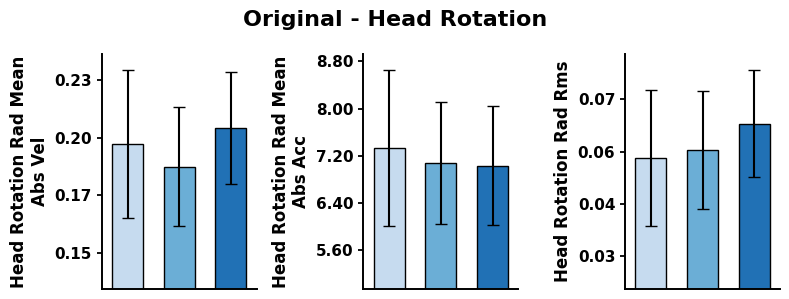

    Saved: pose_original_head_rotation.svg
  Plotting Blink: 3 metrics


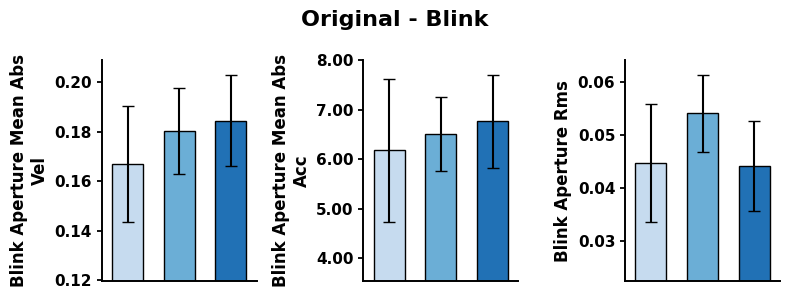

    Saved: pose_original_blink.svg
  Plotting Mouth: 3 metrics


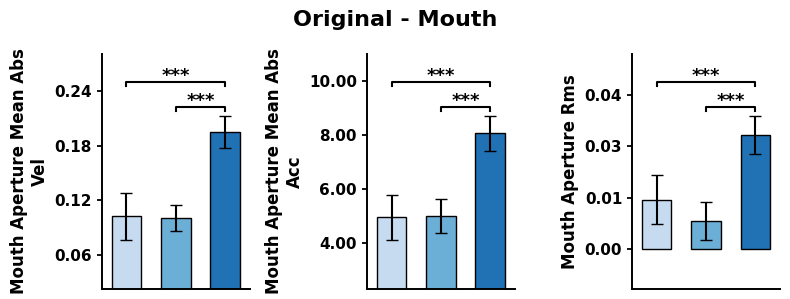

    Saved: pose_original_mouth.svg
  Plotting Pupil: 9 metrics


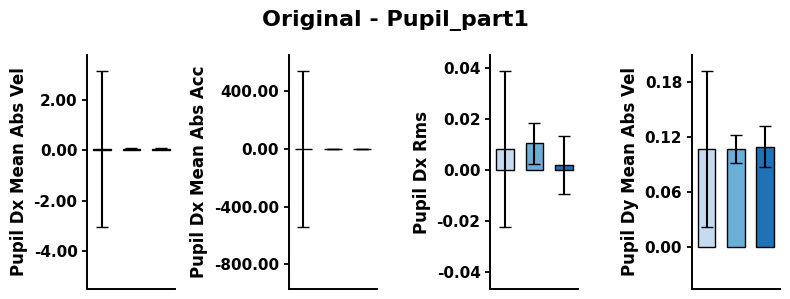

    Saved: pose_original_pupil_part1.svg


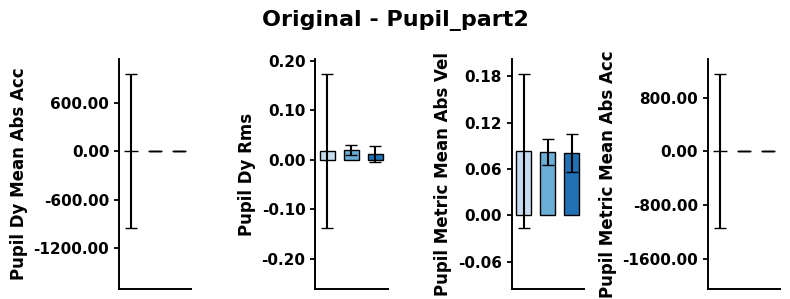

    Saved: pose_original_pupil_part2.svg


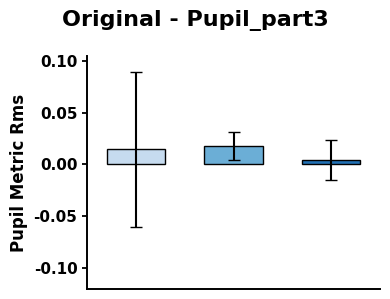

    Saved: pose_original_pupil_part3.svg
  Plotting Center Face: 9 metrics


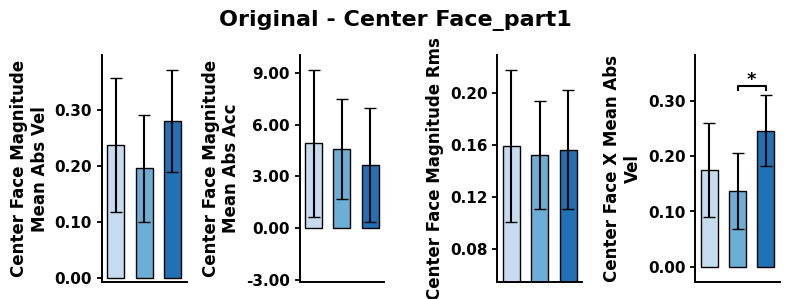

    Saved: pose_original_center_face_part1.svg


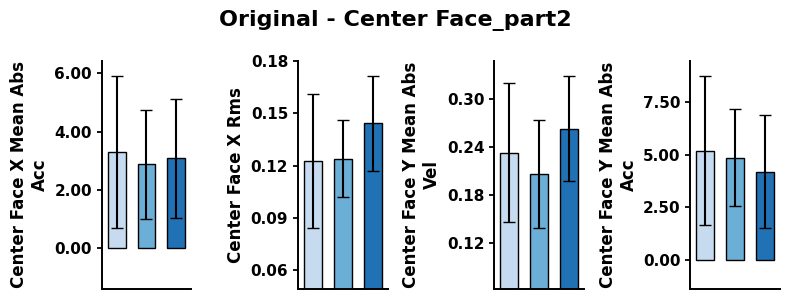

    Saved: pose_original_center_face_part2.svg


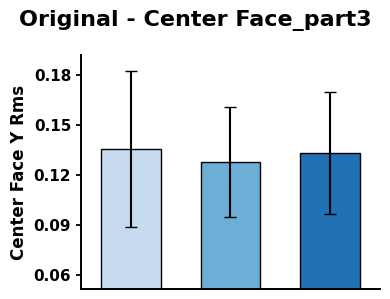

    Saved: pose_original_center_face_part3.svg


Plotting procrustes_global results...
  Total metrics analyzed: 18
  Metrics with significant effects: 6
  Will plot ALL 18 metrics
  Plotting Head Rotation: 3 metrics


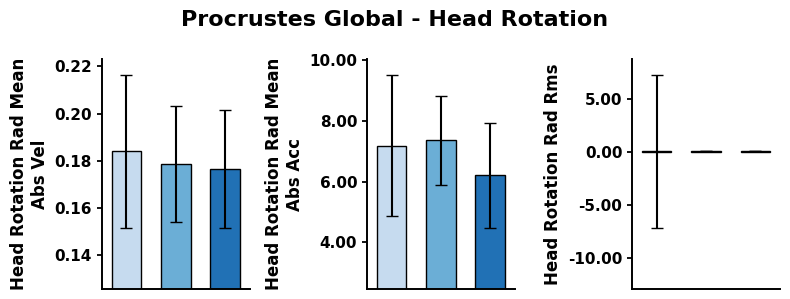

    Saved: pose_procrustes_global_head_rotation.svg
  Plotting Blink: 3 metrics


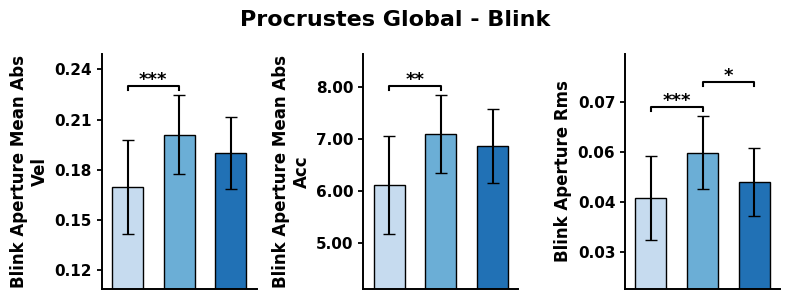

    Saved: pose_procrustes_global_blink.svg
  Plotting Mouth: 3 metrics


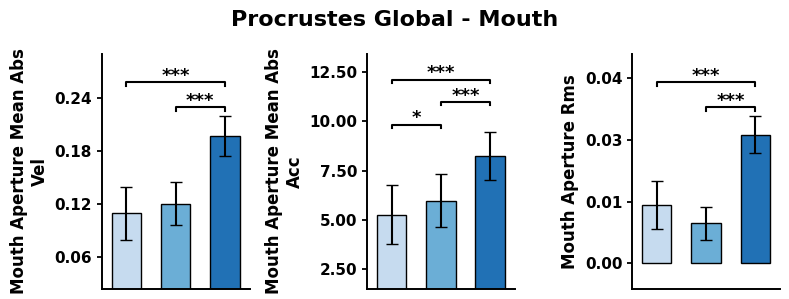

    Saved: pose_procrustes_global_mouth.svg
  Plotting Pupil: 9 metrics


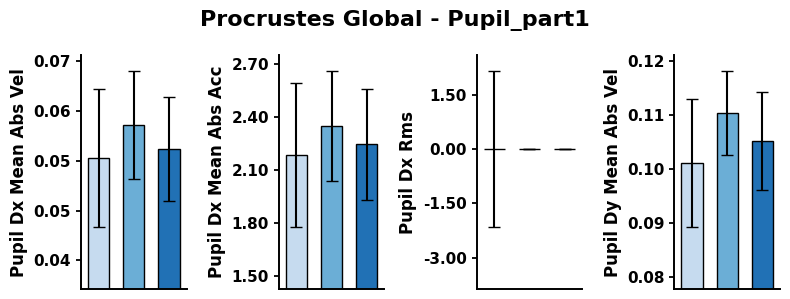

    Saved: pose_procrustes_global_pupil_part1.svg


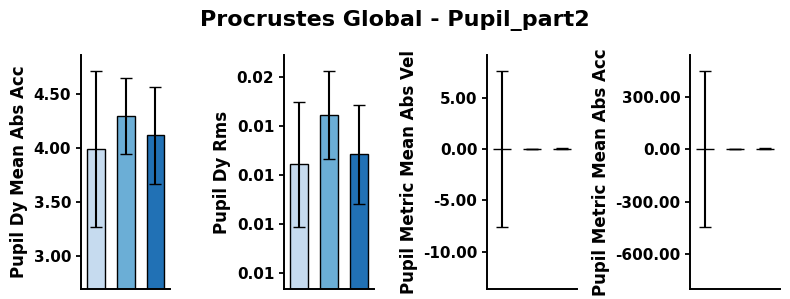

    Saved: pose_procrustes_global_pupil_part2.svg


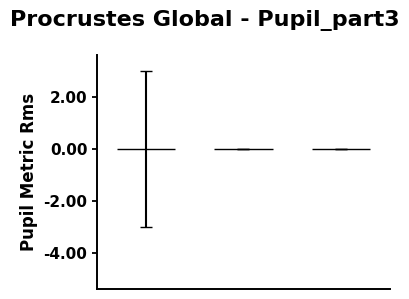

    Saved: pose_procrustes_global_pupil_part3.svg


Plotting procrustes_participant results...
  Total metrics analyzed: 18
  Metrics with significant effects: 6
  Will plot ALL 18 metrics
  Plotting Head Rotation: 3 metrics


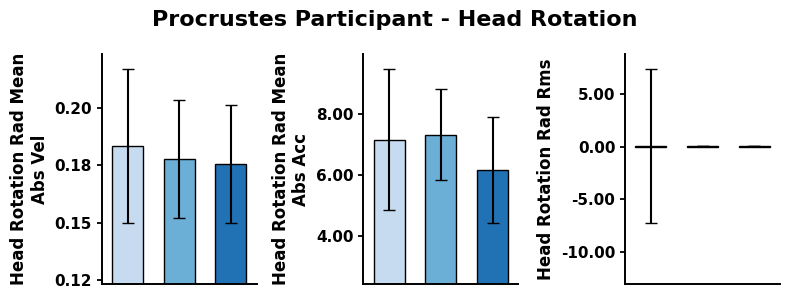

    Saved: pose_procrustes_participant_head_rotation.svg
  Plotting Blink: 3 metrics


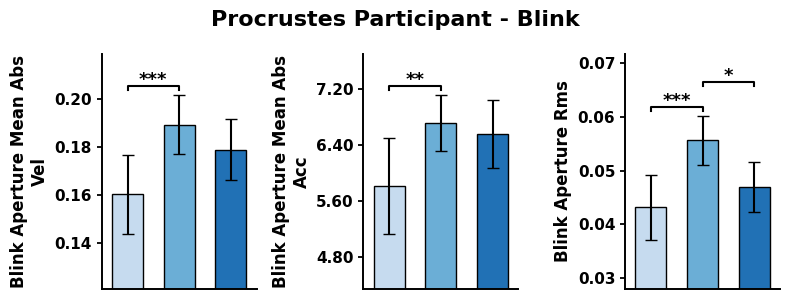

    Saved: pose_procrustes_participant_blink.svg
  Plotting Mouth: 3 metrics


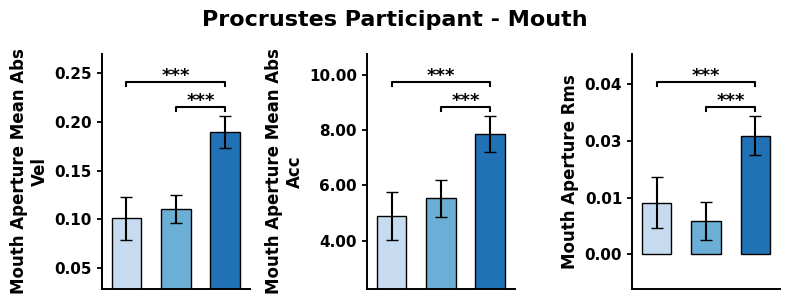

    Saved: pose_procrustes_participant_mouth.svg
  Plotting Pupil: 9 metrics


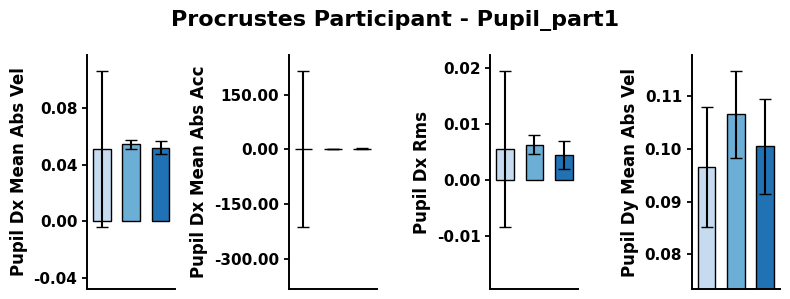

    Saved: pose_procrustes_participant_pupil_part1.svg


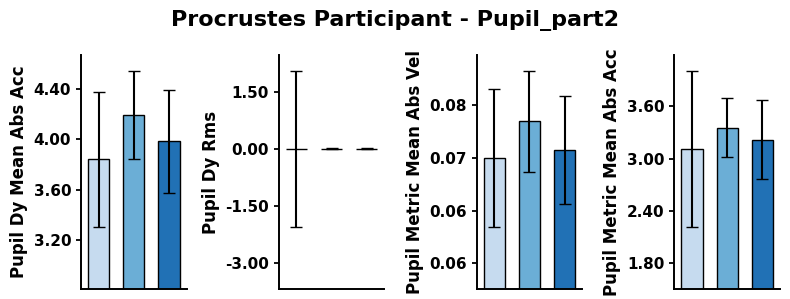

    Saved: pose_procrustes_participant_pupil_part2.svg


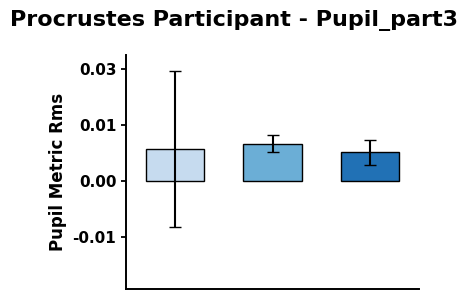

    Saved: pose_procrustes_participant_pupil_part3.svg


All plots generated!


In [14]:
# ===== PLOTTING CONFIGURATION =====
# Configure which plots to generate

# Plotting options
SAVE_FIGURES = True
FIGSIZE = (8, 3)  # Wider to accommodate more subplots
MAX_PLOTS_PER_FIGURE = 4  # Maximum number of metrics per figure
SHOW_PLOTS = True  # Set to False to only save figures without displaying
PLOT_ALL_METRICS = True  # Set to False to only plot significant metrics

# Create output directory if saving
if SAVE_FIGURES:
    os.makedirs("./figs", exist_ok=True)

# Generate plots for each normalization method
for method, method_results in results.items():
    if not method_results:
        continue
        
    print(f"\n\nPlotting {method} results...")
    
    # Get all metrics and significant metrics
    significant_metrics = []
    all_metrics = []
    
    for metric, res in method_results.items():
        all_metrics.append((metric, res))
        # Check if any comparison is significant
        has_sig = any(p < 0.05 for p in res["pvals"].values() if not np.isnan(p))
        if has_sig:
            significant_metrics.append((metric, res))
    
    print(f"  Total metrics analyzed: {len(all_metrics)}")
    print(f"  Metrics with significant effects: {len(significant_metrics)}")
    
    # Choose which metrics to plot based on configuration
    if PLOT_ALL_METRICS:
        metrics_to_plot = all_metrics
        print(f"  Will plot ALL {len(metrics_to_plot)} metrics")
    else:
        metrics_to_plot = significant_metrics if significant_metrics else all_metrics
        print(f"  Will plot {len(metrics_to_plot)} metrics (significant only)")
    
    if not metrics_to_plot:
        print(f"  No metrics to plot for {method}")
        continue
    
    # Group metrics by feature type for organized plotting
    metric_groups = {
        "Head Rotation": [],
        "Blink": [],
        "Mouth": [],
        "Pupil": [],
        "Center Face": [],
        "Procrustes Transform": []
    }
    
    # Categorize metrics
    for metric, res in metrics_to_plot:
        if "head_rotation" in metric:
            metric_groups["Head Rotation"].append((metric, res))
        elif "blink" in metric:
            metric_groups["Blink"].append((metric, res))
        elif "mouth" in metric:
            metric_groups["Mouth"].append((metric, res))
        elif "pupil" in metric:
            metric_groups["Pupil"].append((metric, res))
        elif "center_face" in metric:
            metric_groups["Center Face"].append((metric, res))
        elif any(x in metric for x in ["head_tx", "head_ty", "head_scale", "head_motion"]):
            metric_groups["Procrustes Transform"].append((metric, res))
        else:
            # Default to Center Face for unrecognized metrics
            metric_groups["Center Face"].append((metric, res))
    
    # Create plots for each group that has metrics
    for group_name, group_metrics in metric_groups.items():
        if not group_metrics:
            continue
            
        print(f"  Plotting {group_name}: {len(group_metrics)} metrics")
        
        # Create multiple figures if needed (chunk metrics)
        for chunk_idx in range(0, len(group_metrics), MAX_PLOTS_PER_FIGURE):
            chunk = group_metrics[chunk_idx:chunk_idx + MAX_PLOTS_PER_FIGURE]
            n_plots = len(chunk)
            
            # Create figure
            if n_plots == 1:
                fig, ax = plt.subplots(1, 1, figsize=(FIGSIZE[0]//2, FIGSIZE[1]))
                axes = [ax]
            else:
                cols = min(n_plots, 4)  # Max 4 columns
                rows = (n_plots + cols - 1) // cols  # Calculate needed rows
                fig, axes = plt.subplots(rows, cols, figsize=(FIGSIZE[0], FIGSIZE[1] * rows))
                if rows == 1:
                    axes = axes if n_plots > 1 else [axes]
                else:
                    axes = axes.flatten()
            
            # Plot each metric in the chunk
            for idx, (metric, res) in enumerate(chunk):
                if idx >= len(axes):
                    break
                    
                ax = axes[idx]
                order = ['L', 'M', 'H']
                means = [res["means"].get(lvl, np.nan) for lvl in order]
                cis = [res["cis"].get(lvl, (np.nan, np.nan)) for lvl in order]
                
                # Convert CIs to SEMs
                sems = []
                for ci in cis:
                    if ci is not None and isinstance(ci, (tuple, list)) and len(ci) == 2:
                        if not np.isnan(ci[0]) and not np.isnan(ci[1]):
                            sems.append((ci[1] - ci[0]) / 3.92)
                        else:
                            sems.append(np.nan)
                    else:
                        sems.append(np.nan)
                
                if all(np.isnan(m) for m in means):
                    ax.text(0.5, 0.5, f"No data\n{res['label']}", 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    continue
                
                # Get p-values
                pvals = (
                    res["pvals"].get(('L','M'), np.nan),
                    res["pvals"].get(('L','H'), np.nan),
                    res["pvals"].get(('M','H'), np.nan)
                )
                
                # Create bar plot
                barplot_ax(ax, means, sems, pvals, res["label"], metric_name=metric, 
                          colors=col_pal, bar_width=0.6)
            
            # Hide extra subplots
            for idx in range(len(chunk), len(axes)):
                axes[idx].set_visible(False)
            
            # Add overall title
            chunk_suffix = f"_part{chunk_idx//MAX_PLOTS_PER_FIGURE + 1}" if len(group_metrics) > MAX_PLOTS_PER_FIGURE else ""
            title = f"{method.replace('_', ' ').title()} - {group_name}{chunk_suffix}"
            fig.suptitle(title, fontweight='bold', fontsize=16)
            
            # Adjust layout
            plt.tight_layout()
            
            if SHOW_PLOTS:
                plt.show()
            
            # Save figure
            if SAVE_FIGURES:
                safe_group_name = group_name.replace(' ', '_').replace('/', '_').lower()
                filename = f"pose_{method}_{safe_group_name}{chunk_suffix}.svg"
                fig.savefig(f"./figs/{filename}", dpi=300, bbox_inches='tight')
                print(f"    Saved: {filename}")
            
            plt.close(fig)  # Close figure to free memory

print("\n\nAll plots generated!")

In [15]:
# Generate summary of significant effects
print("\n" + "="*60)
print("SUMMARY OF SIGNIFICANT EFFECTS (p < 0.05)")
print("="*60)

for method, method_results in results.items():
    sig_effects = []
    
    for metric, res in method_results.items():
        sig_comparisons = []
        for (g1, g2), p in res["pvals"].items():
            if p < 0.05:
                stars = "***" if p < 0.001 else "**" if p < 0.01 else "*"
                sig_comparisons.append(f"{g1}v{g2}{stars}")
        
        if sig_comparisons:
            sig_effects.append(f"  {res['label']}: {', '.join(sig_comparisons)}")
    
    if sig_effects:
        print(f"\n{method.upper()} NORMALIZATION:")
        for effect in sig_effects:
            print(effect)
    else:
        print(f"\n{method.upper()} NORMALIZATION: No significant effects")

print("\n" + "="*60)
print("* p < 0.05, ** p < 0.01, *** p < 0.001")


SUMMARY OF SIGNIFICANT EFFECTS (p < 0.05)

ORIGINAL NORMALIZATION:
  Mouth Aperture Mean Abs Vel: LvH***, MvH***
  Mouth Aperture Mean Abs Acc: LvH***, MvH***
  Mouth Aperture Rms: LvH***, MvH***
  Center Face X Mean Abs Vel: MvH*

PROCRUSTES_GLOBAL NORMALIZATION:
  Blink Aperture Mean Abs Vel: LvM***
  Blink Aperture Mean Abs Acc: LvM**
  Blink Aperture Rms: LvM***, MvH*
  Mouth Aperture Mean Abs Vel: LvH***, MvH***
  Mouth Aperture Mean Abs Acc: LvM*, LvH***, MvH***
  Mouth Aperture Rms: LvH***, MvH***

PROCRUSTES_PARTICIPANT NORMALIZATION:
  Blink Aperture Mean Abs Vel: LvM***
  Blink Aperture Mean Abs Acc: LvM**
  Blink Aperture Rms: LvM***, MvH*
  Mouth Aperture Mean Abs Vel: LvH***, MvH***
  Mouth Aperture Mean Abs Acc: LvH***, MvH***
  Mouth Aperture Rms: LvH***, MvH***

* p < 0.05, ** p < 0.01, *** p < 0.001


In [16]:
# Export results to CSV for further analysis
summary_data = []

for method, method_results in results.items():
    for metric, res in method_results.items():
        row = {
            'normalization': method,
            'metric': metric,
            'group': res['group'],
            'mean_L': res['means'].get('L', np.nan),
            'mean_M': res['means'].get('M', np.nan),
            'mean_H': res['means'].get('H', np.nan),
            'p_L_M': res['pvals'].get(('L', 'M'), np.nan),
            'p_L_H': res['pvals'].get(('L', 'H'), np.nan),
            'p_M_H': res['pvals'].get(('M', 'H'), np.nan),
        }
        summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('./pose_stats_summary.csv', index=False)
print(f"Results summary saved to pose_stats_summary.csv")
print(f"Total metrics analyzed: {len(summary_df)}")

# Show metrics with strongest effects (lowest p-values)
print("\nTop 10 metrics with strongest condition effects (L vs H):")
top_effects = summary_df.nsmallest(10, 'p_L_H')[['normalization', 'metric', 'p_L_H']]
for _, row in top_effects.iterrows():
    print(f"  {row['normalization']}: {row['metric']} (p={row['p_L_H']:.4f})")

Results summary saved to pose_stats_summary.csv
Total metrics analyzed: 63

Top 10 metrics with strongest condition effects (L vs H):
  procrustes_global: mouth_aperture_mean_abs_acc (p=0.0000)
  procrustes_global: mouth_aperture_mean_abs_vel (p=0.0000)
  procrustes_participant: mouth_aperture_mean_abs_acc (p=0.0000)
  original: mouth_aperture_mean_abs_acc (p=0.0000)
  procrustes_participant: mouth_aperture_mean_abs_vel (p=0.0000)
  original: mouth_aperture_mean_abs_vel (p=0.0000)
  procrustes_global: mouth_aperture_rms (p=0.0000)
  procrustes_participant: mouth_aperture_rms (p=0.0000)
  original: mouth_aperture_rms (p=0.0000)
  procrustes_global: blink_aperture_mean_abs_vel (p=0.0799)
